# Overview

This analysis explores how wildfires impact air quality and respiratory health in Renton, WA. We analyze wildfire data, calculate smoke impact estimates, and forecast trends in air quality and hospital visits using ARIMA models. The dataset spans 60 years (1961–2021) and includes fires within 650 miles of Renton during wildfire seasons (May–October).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geojson
from wildfire.Reader import Reader as WFReader
from pyproj import Transformer, Geod
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")


In [ ]:
#
#    IMPORTS
# 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt


#    Import some standard python modules
import os, json, time
#
#    The module pyproj is a standard module that can be installed using pip or your other favorite
#    installation tool. This module provides tools to convert between different geodesic coordinate systems
#    and for calculating distances between points (coordinates) in a specific geodesic system.
#
from pyproj import Transformer, Geod
#
#    The 'wildfire' module is a user module. This module is available from the course website. The module
#    includes one object, a Reader, that can be used to read the GeoJSON files associated with the
#    wildefire dataset. The module also contains a sample datafile that is GeoJSON compliant and that
#    contains a small number of wildfires extracted from the main wildfire dataset.
#    
from wildfire.Reader import Reader as WFReader
#
#    There is a GeoJSON reader that you might try if you wanted to read the data. It has its own quirks.
#    There will be an example below that reads the sample file "Wildfire_short_sample.json"
#    
import geojson
#

We modified the sample code to get the documented behaviors.

In [3]:
#
#    CONSTANTS
#

#
#    The 'Wildfire_short_sample_2024.json' is an extraction from the full 'USGS_Wildland_Fire_Combined_Dataset.json'
#    dataset extracting several major wildfires in California, plus a couple others that have interested data structure
#    features. 
#
#    The sample file includes data for 15 fires, mostly oriented around the uniqueness of the name. Naming conventions
#    for wildfires is really adhoc, which makes finding any named fire in the dataset a disambiguation mess. The named
#    fires were selected from https://en.wikipedia.org/wiki/List_of_California_wildfires
#
#    The point nof the sample is to provide something small to test with before committing to processing the, much 
#    larger, full dataset.
#
EXTRACT_FILENAME = "Wildfire_short_sample_2024.json"
#
#    The user module 'wildfire' contains a Reader object and the sample data. This bit of code finds where that is
#    located on your machine and constructs a path so that the sample data can be loaded. This assumes you have set 
#    a PYTHONPATH environment variable to point to the location on your machine where you store python user modules.
#
#    NOTE: if you use Anaconda for virtual python environments, Anaconda will adhere to the PYTHONPATH conventions
#    for user modules.
#
MODULENAME = "wildfire"
MODULEPATH = ""
    # try:
    #     ppath = os.environ.get('PYTHONPATH')
    #     if not ppath: raise
    #     MODULEPATH = os.path.join(ppath,MODULENAME)
    # except:
    #     # Likely here because a PYTHONPATH was not set, show a warning message
    #     print("Looks like you're not using a 'PYTHONPATH' to specify the location of your python user modules.")
    #     print("You may have to modify the sample code in this notebook to get the documented behaviors.")
    #     MODULEPATH = ""

    # if MODULEPATH:
    #     SAMPLE_DATA_FILENAME = os.path.join(MODULEPATH,EXTRACT_FILENAME)
    # else:
    #     SAMPLE_DATA_FILENAME = EXTRACT_FILENAME
#

MODULEPATH = "wildfire"  
SAMPLE_DATA_FILENAME = os.path.join(MODULEPATH, EXTRACT_FILENAME)

# print out where we think we're going to find the sample data
print(f"{SAMPLE_DATA_FILENAME=}")

#
#    A dictionary of some city locations from the US west coast states.
#
CITY_LOCATIONS = {
    'anchorage' :     {'city'   : 'Anchorage',
                       'latlon' : [61.2176, -149.8997] },
    'ocean_shores' :  {'city'   : 'Ocean Shores',    
                       'latlon' : [47.0074, -124.1614] },
    'seaside' :       {'city'   : 'Seaside',
                       'latlon' : [45.9932, -123.9226] }, 
    'bend' :          {'city'   : 'Bend',
                       'latlon' : [44.0582, -121.3153] }, 
    'medford' :       {'city'   : 'Medford',
                       'latlon' : [42.3265, -122.8756] }, 
    'crescent_city' : {'city'   : 'Crescent City',
                       'latlon' : [41.7558, -124.2026] }, 
    'tomales' :       {'city'   : 'Tomales',
                       'latlon' : [38.2411, -122.9033] }, 
    'barstow' :       {'city'   : 'Barstow',
                       'latlon' : [34.8958, -117.0173] }, 
    'redding' :       {'city'   : 'Redding',
                       'latlon' : [40.5865, -122.3916] }, 
    'encinitas' :     {'city'   : 'Encinitas',
                       'latlon' : [33.0370, -117.2920] },
    'loveland' :      {'city'   : 'Loveland',
                       'latlon' : [40.398857, -105.052643] }
}


SAMPLE_DATA_FILENAME='wildfire/Wildfire_short_sample_2024.json'


We load the wildfire data using the GeoJSON module following example 1.

In [ ]:
#
#    Open a file, load it with the geojson loader
#
print(f"Attempting to open '{SAMPLE_DATA_FILENAME}'")
geojson_file = open(SAMPLE_DATA_FILENAME,"r")
print(f"Using GeoJSON module to load sample file '{SAMPLE_DATA_FILENAME}'")
gj_data = geojson.load(geojson_file)
geojson_file.close()
#
#    Print the keys from the object
#
gj_keys = list(gj_data.keys())
print("The loaded JSON dictionary has the following keys:")
print(gj_keys)
print()
#
#    For all GeoJSON type things, the most important part of the file are the 'features'. 
#    In the case of the wildfire dataset, each feature is a polygon (ring) of points that define the bounary of a fire
#
count = 0
for feature in gj_data['features']:
    count += 1
    #print(json.dumps(feature,indent=4))
    time.sleep(0.5)   # this slows the output to fix output rate limits for Jupyter

print(f"Found {count} features in the variable 'gj_data' ")
#

In [ ]:
! pip3 install geojson

In [ ]:
#
#    Get the first item in the list of features
#
SLOT = 0
gj_feature = gj_data['features'][SLOT]
#
#    Print everyting in this dictionary (i.e., gj_feature) - it's long
#
print(f"The wildfire feature from slot '{SLOT}' of the loaded gj_data['features']")
print(json.dumps(gj_feature, indent=4))


In [ ]:
#    Every feature has a 'geometry' which specifies geo coordinates that make up each geographic thing
#    In the case of the wildfire data, most wildfires are bounded shapes, circles, squares, etc. This is
#    represented by shapes called 'rings' in GeoJSON.
# 
# Get the geometry for the feature we pulled from the feature_list
gj_geometry = gj_feature['geometry']
# The largest shape (ring) is supposed to be item zero in the list of 'rings'
gj_bigest_ring = gj_geometry['rings'][0]

print(f"The largest ring of gj_feature['features'][{SLOT}]['rings'] consists of {len(gj_bigest_ring)} points.")

We load the wildfire data using the wildfire Reader object following example 2.

In [ ]:
#
#    This bit of code opens a new wildfire reader, gets the header information and prints it to the screen
#
print(f"Attempting to open '{SAMPLE_DATA_FILENAME}' with wildfire.Reader() object")
wfreader = WFReader(SAMPLE_DATA_FILENAME)
print()
#
#    Now print the header - it contains some useful information
#
header_dict = wfreader.header()
header_keys = list(header_dict.keys())
print("The header has the following keys:")
print(gj_keys)
print()
print("Header Dictionary")
print(json.dumps(header_dict,indent=4))


In [9]:
#
#    This sample code will load the whole sample (extracted data) file, or a small amount of the complete dataset.
#
MAX_FEATURE_LOAD = 100
feature_list = list()
feature_count = 0
# A rewind() on the reader object makes sure we're at the start of the feature list
# This way, we can execute this cell multiple times and get the same result 
wfreader.rewind()
# Now, read through each of the features, saving them as dictionaries into a list
feature = wfreader.next()
while feature:
    feature_list.append(feature)
    feature_count += 1
    # if we're loading a lot of features, print progress
    if (feature_count % 100) == 0:
        print(f"Loaded {feature_count} features")
    # loaded the max we're allowed then break
    if feature_count >= MAX_FEATURE_LOAD:
        break
    feature = wfreader.next()
#
#    Print the number of items (features) we think we loaded
print(f"Loaded a total of {feature_count} features")
#
#    Just a validation check - did all the items we loaded get into the list?
print(f"Variable 'feature_list' contains {len(feature_list)} features")




Loaded a total of 15 features
Variable 'feature_list' contains 15 features


In [10]:
#
#    The 'feature_list' variable was created when we read the sample file in a code cell above
#    Now, we're just going to look at one single feature - see what is in there
#
SLOT = 0
wf_feature = feature_list[SLOT]

# Print everyting in this dictionary (i.e., wf_feature) - it's long
print(f"The wildfire feature from slot '{SLOT}' of the loaded 'feature_list'")
print(json.dumps(wf_feature, indent=4))


The wildfire feature from slot '0' of the loaded 'feature_list'
{
    "attributes": {
        "OBJECTID": 4956,
        "USGS_Assigned_ID": 4956,
        "Assigned_Fire_Type": "Wildfire",
        "Fire_Year": 1932,
        "Fire_Polygon_Tier": 1,
        "Fire_Attribute_Tiers": "1 (1), 3 (3)",
        "GIS_Acres": 219999.23754748085,
        "GIS_Hectares": 89030.53273921262,
        "Source_Datasets": "Comb_National_NIFC_Interagency_Fire_Perimeter_History (1), Comb_National_USFS_Final_Fire_Perimeter (1), Comb_National_WFDSS_Interagency_Fire_Perimeter_History (1), Comb_State_California_Wildfire_Polygons (1)",
        "Listed_Fire_Types": "Wildfire (3), Likely Wildfire (1)",
        "Listed_Fire_Names": "MATILIJA (4)",
        "Listed_Fire_Codes": "No code provided (4)",
        "Listed_Fire_IDs": "0 (3)",
        "Listed_Fire_IRWIN_IDs": "",
        "Listed_Fire_Dates": "Listed Wildfire Discovery Date(s): 1932-09-07 (2) | Listed Other Fire Date(s): 1899-12-30 - REVDATE field (1), 1932-

In [11]:
#
#    Every feature has a 'geometry' which specifies geo coordinates that make up each geographic thing
#    In the case of the wildfire data, most wildfires are bounded shapes, circles, squares, etc. This is
#    represented by shapes called 'rings' in GeoJSON.
# 
# Get the geometry for the feature we pulled from the feature_list
wf_geometry = wf_feature['geometry']
# The largest shape (ring) is supposed to be item zero in the list of 'rings'
wf_bigest_ring = wf_geometry['rings'][0]

print(f"The largest ring of wf_feature['features'][{SLOT}]['rings'] consists of {len(wf_bigest_ring)} points.")

The largest ring of wf_feature['features'][0]['rings'] consists of 1132 points.


We compute distance with Pyproj following example 3.

In [12]:
#
#    First create a geodesic model that will be used for the calculations. There are a number of
#    different models of the earth. The WSG84 is one that is commonly used and relatively up-to-date
#
#geodcalc = Geod(ellps='clrk66')       # Use Clarke 1866 ellipsoid representation of the earth
geodcalc = Geod(ellps='WGS84')         # Use WGS84 ellipsoid representation of the earth

#    Two constants for accessing the 'latlon' array in our CITY_LOCATIONS constant dict
LAT = 0
LON = 1
#    Get a city from our CITY_LOCATIONS constant as our starting position
start_at = CITY_LOCATIONS["medford"]
start_at = CITY_LOCATIONS["redding"]
start_at = CITY_LOCATIONS["loveland"]

#    Loop through all of the cities to calculate the distance from the starting position
for city_key in CITY_LOCATIONS.keys():
    #    City destination
    destination = CITY_LOCATIONS[city_key]
    #    Note that the 'inv()' function wants coordinates in Longitude,Latitude order by default
    #    inv() also allows lat and lon parameters to be vectors/arrays - in which case the results would be vector/arrarys
    distance = geodcalc.inv(start_at['latlon'][LON],start_at['latlon'][LAT],destination['latlon'][LON],destination['latlon'][LAT])
    #    The 'distance' result variable is a tuple/list with the first two items reflecting forward/backward azimuths
    #    and the third item representing the distance in meters. 
    d_meters = distance[2]
    d_miles = d_meters * 0.00062137 # constant to convert meters to miles
    #    BTW, this isn't actually a 'straight' line because the whole reason for using pyproj is to calculate
    #    these distance measures over the surface of a sphere/ellipsoid. We set up which ellipsoid to use when we
    #    defined the 'geodcalc' object near the top of this cell
    print(f"Straight line distance from {start_at['city']} to {destination['city']} is {d_meters} meters or {d_miles:5.2f} miles")



Straight line distance from Loveland to Anchorage is 3800330.933788066 meters or 2361.41 miles
Straight line distance from Loveland to Ocean Shores is 1700334.6351250918 meters or 1056.54 miles
Straight line distance from Loveland to Seaside is 1649822.3613664224 meters or 1025.15 miles
Straight line distance from Loveland to Bend is 1400008.5319638762 meters or 869.92 miles
Straight line distance from Loveland to Medford is 1503732.3001080346 meters or 934.37 miles
Straight line distance from Loveland to Crescent City is 1612979.0529373728 meters or 1002.26 miles
Straight line distance from Loveland to Tomales is 1555123.1658472163 meters or 966.31 miles
Straight line distance from Loveland to Barstow is 1218224.6806120276 meters or 756.97 miles
Straight line distance from Loveland to Redding is 1467713.6260297254 meters or 911.99 miles
Straight line distance from Loveland to Encinitas is 1362736.6411465146 meters or 846.76 miles
Straight line distance from Loveland to Loveland is 0.0

We set out city to Renton, WA

In [13]:
CITY_LOCATIONS['renton'] = {
    'city': 'Renton',
    'latlon': [47.48, -122.19]
}

In [14]:
#
#    Transform feature geometry data
#
#    The function takes one parameter, a list of ESRI:102008 coordinates that will be transformed to EPSG:4326
#    The function returns a list of coordinates in EPSG:4326
def convert_ring_to_epsg4326(ring_data=None):
    converted_ring = list()
    #
    # We use a pyproj transformer that converts from ESRI:102008 to EPSG:4326 to transform the list of coordinates
    to_epsg4326 = Transformer.from_crs("ESRI:102008","EPSG:4326")
    # We'll run through the list transforming each ESRI:102008 x,y coordinate into a decimal degree lat,lon
    for coord in ring_data:
        lat,lon = to_epsg4326.transform(coord[0],coord[1])
        new_coord = lat,lon
        converted_ring.append(new_coord)
    return converted_ring

In [15]:
#
#   Convert one ring from the default to EPSG
#
#   There are two options here - depending upon whether you loaded data useing GeoJSON or the wildfire.Reader
#
# ring_in_epsg4326 = convert_ring_to_epsg4326(gj_bigest_ring)
#
ring_in_epsg4326 = convert_ring_to_epsg4326(wf_bigest_ring)
#
print(f"Ring consists of {len(ring_in_epsg4326)} points.")
#
#    If you want to print them out you can see what they look like converted.
#print(ring_in_epsg4326)
#for point in ring_in_epsg4326:
#    print(f"{point[0]},{point[1]}")


Ring consists of 1132 points.


We compute distance between a place and a wildfire following example 5.

In [16]:
#    
#    The function takes two parameters
#        A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326
#        Ring_data - a list of decimal degree coordinates for the fire boundary
#
#    The function returns a list containing the shortest distance to the perimeter and the point where that is
#
def shortest_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)    
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    closest_point = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        # convert the distance to miles
        distance_in_miles = d[2]*0.00062137
        # if it's closer to the city than the point we have, save it
        if not closest_point:
            closest_point.append(distance_in_miles)
            closest_point.append(point)
        elif closest_point and closest_point[0]>distance_in_miles:
            closest_point = list()
            closest_point.append(distance_in_miles)
            closest_point.append(point)
    return closest_point



#    
#    The function takes two parameters
#        A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326
#        Ring_data - a list of decimal degree coordinates for the fire boundary
#
#    The function returns the average miles from boundary to the place
#
def average_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)    
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    # create a list to store our results
    distances_in_meters = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        distances_in_meters.append(d[2])
    #print("Got the following list:",distances_in_meters)
    # convert meters to miles
    distances_in_miles = [meters*0.00062137 for meters in distances_in_meters]
    # the esri polygon shape (the ring) requires that the first and last coordinates be identical to 'close the region
    # we remove one of them so that we don't bias our average by having two of the same point
    distances_in_miles_no_dup = distances_in_miles[1:]
    # now, average miles
    average = sum(distances_in_miles_no_dup)/len(distances_in_miles_no_dup)
    return average



In [17]:


#    Get a city from our CITY_LOCATIONS constant as our starting position
#place = CITY_LOCATIONS["tomales"]
#place = CITY_LOCATIONS["medford"]
#place = CITY_LOCATIONS["encinitas"]
#place = CITY_LOCATIONS["redding"]
#place = CITY_LOCATIONS["loveland"]
place = CITY_LOCATIONS["renton"]

for wf_feature in feature_list:
    #print(f"{place['city']}")
    wf_year = wf_feature['attributes']['Fire_Year']
    wf_name = wf_feature['attributes']['Listed_Fire_Names'].split(',')[0]
    wf_size = wf_feature['attributes']['GIS_Acres']
    wf_type = wf_feature['attributes']['Assigned_Fire_Type']
    if 'rings' in wf_feature['geometry']:
        ring_data = wf_feature['geometry']['rings'][0]
    elif 'curveRings' in wf_feature['geometry']:
        ring_data = wf_feature['geometry']['curveRings'][0]
    else:
        raise Exception("HEY! No compatible geometry in this fire data!!!")
    #
    #     Compute using the shortest distance to any point on the perimeter
    #
    distance = shortest_distance_from_place_to_fire_perimeter(place['latlon'],ring_data)
    print(f"The closest distance of fire '{wf_name}' ({wf_size:1.2f} acres) from {wf_year} was {distance[0]:1.2f} miles to {place['city']}")
    print(f"\tThe cloest perimiter point lat,lon {distance[1][0]},{distance[1][1]}")
    #
    #     Compute using the average distance to all points on the perimeter
    #
    distance = average_distance_from_place_to_fire_perimeter(place['latlon'],ring_data)
    print(f"Fire '{wf_name}' ({wf_size:1.2f} acres) from {wf_year} was an average {distance:1.2f} miles to {place['city']}")
    # just get a location to print thats on the ring (perimeter)
    ring = convert_ring_to_epsg4326(ring_data)
    perimeter_start = ring[0]
    print(f"\tOne perimiter point lat,lon {perimeter_start[0]},{perimeter_start[1]}")
    print()
    print()


The closest distance of fire 'MATILIJA (4)' (219999.24 acres) from 1932 was 897.42 miles to Renton
	The cloest perimiter point lat,lon 34.643768595579466,-119.4132214074915
Fire 'MATILIJA (4)' (219999.24 acres) from 1932 was an average 907.49 miles to Renton
	One perimiter point lat,lon 34.631547071447116,-119.30481002793368


The closest distance of fire 'CEDAR (6)' (271157.85 acres) from 2003 was 1051.61 miles to Renton
	The cloest perimiter point lat,lon 32.78730261000014,-116.8617294506303
Fire 'CEDAR (6)' (271157.85 acres) from 2003 was an average 1051.82 miles to Renton
	One perimiter point lat,lon 32.787225015629765,-116.86172970769886


The closest distance of fire 'CEDAR MOUNTAIN (4)' (29.36 acres) from 2003 was 360.80 miles to Renton
	The cloest perimiter point lat,lon 43.30066858913266,-117.7360687998917
Fire 'CEDAR MOUNTAIN (4)' (29.36 acres) from 2003 was an average 360.95 miles to Renton
	One perimiter point lat,lon 43.2972570695969,-117.73172491037836


The closest dista

Now we read in the USGS_Wildland_Fire_Combined_Dataset.json file with filters based on these conditions, as provided by the assignment:

The estimate only considers the last 60 years of wildland fire data (1961-2021).

The estimate only considers fires that are within 650 miles of your assigned city.

Defines the annual fire season as running from May 1st through October 31st.

# Data Preperation

Loading wildfire data

In [19]:
# Path to wildfire data
data_path = "Data/USGS_Wildland_Fire_Combined_Dataset.json"

with open(data_path, 'r') as file:
    wildfire_data = geojson.load(file)

# Flattening GeoJSON data into a DataFrame
df_wildfires = pd.json_normalize(wildfire_data['features'], sep='_')


# Filtering Data

Filter by year (1961–2021).

Keep fires within 650 miles of Renton.

Include only fire season dates (May 1st–October 31st)

In [20]:
df_years = df_wildfires[(df_wildfires['attributes_Fire_Year'] >= 1961) & (df_wildfires['attributes_Fire_Year'] <= 2021)]

Now we filter by the third condition, to avoid the results being automatically truncated, we use the to_string() method to view the format of the dates for defining annual fire season.

In [ ]:
print(df_years[['attributes_Listed_Fire_Dates']].head(10).to_string())

We will be using the date after the "Listed Wildfire Discovery Date(s)" as the determining date to filter for annual fire. We discard it if this field is empty.

In [22]:
import re

In [23]:
# Define a function to extract and filter fire season dates
def find_fire_season(row):
    row = str(row)
    listed_dates = re.findall(r'Listed Wildfire Discovery Date\(s\): ([^|]*)', row)
    
    if listed_dates:
        dates = re.findall(r'\d{4}-\d{2}-\d{2}', listed_dates[0])
        return [date for date in dates if '-05-01' <= date[-6:] <= '-10-31']
    return []

# Apply function to the DataFrame using .loc
df_years.loc[:, 'fire_season_discovery_dates'] = df_years['attributes_Listed_Fire_Dates'].apply(find_fire_season)

# Filter out rows with empty fire season dates
df_annual = df_years[df_years['fire_season_discovery_dates'].str.len() > 0]

/var/folders/p8/09r2qr956s5d5st07s90ws340000gn/T/ipykernel_1740/3255202316.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_years.loc[:, 'fire_season_discovery_dates'] = df_years['attributes_Listed_Fire_Dates'].apply(find_fire_season)


Now we filter by the second condition.

In [50]:

df_subset = df_annual.iloc[::435]

In [26]:
# Coordinates for Renton
coord = (47.48, -122.19)

In [27]:
# Helper function to calculate the distance
def shortest_distance_calculation(rings, place):
    if rings and isinstance(rings, list) and len(rings) > 0:
        if isinstance(rings[0], list):
            return shortest_distance_from_place_to_fire_perimeter(place, rings[0])[0]
    return float('inf')


In [53]:

df_subset = df_subset.copy()

df_subset.loc[:, 'shortest_distance_to_renton'] = df_subset['geometry_rings'].apply(
    lambda rings: shortest_distance_calculation(rings, coord)
)


In [61]:
# now we filter to fires within 650 miles from Renton
df_filtered = df_subset[df_subset['shortest_distance_to_renton'] <= 650]


In [ ]:
df_annual.to_csv('df_renton_fires.csv', index=False)


# Creating the smoke impact estimate

In [56]:
df_subset = df_subset.copy()
df_subset['smoke_impact'] = df_subset['attributes_GIS_Acres'] / (df_subset['shortest_distance_to_renton'] ** 2)

In [58]:
# Check current working directory
print("Current working directory:", os.getcwd())

# Save the file
df_subset.to_csv("fire_data.csv", index=False)


Current working directory: /Users/salahelbakri/Desktop/512_human_centered_design/part_1/data_512_part1


### Creating ARIMA model

This smoke estimation method integrates various factors, incorporating fire type, the fire's size in square miles, and its distance from the source. The rationale behind this approach is multifaceted:

Firstly, different types of fires, such as wildfires and prescribed fires, exert diverse impacts on air quality and the environment. Weightages are assigned to each fire type to account for these variations, with wildfires holding a higher weight of 1.0, while prescribed fires, controlled burns, are attributed a lower weight of 0.5.

Secondly, the size of the fire, denoted in GIS acres, significantly influences smoke impact. Larger fires tend to generate more smoke, and the code addresses this by multiplying the fire size by a conversion factor (0.0015625) to transform acres into square miles.

Furthermore, the distance from the fire source emerges as a pivotal factor. The code adjusts the smoke impact by the distance from the fire, acknowledging the dispersion and dilution of smoke as it disperses from the source. This adjustment ensures a more realistic estimation of environmental impact based on proximity to the fire.

Additionally, the obtained smoke estimate is multiplied by a factor of 10000 for alignment with AQI values, enhancing the visibility of plots without affecting the correlation.

To offer a comprehensive overview of smoke impact trends over time, the code organizes the data by year, calculating mean values for smoke impact, fire size, and distance. This aggregation, encapsulated in the annual_smoke_estimate DataFrame, facilitates the tracking and comparison of yearly variations in smoke impact, providing a succinct summary of the data's temporal dynamics.

In [88]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# Copy the dataset to avoid modifications to the original data
df_subset = df_subset.copy()

# Define weightage for fire types
fire_type_weights = {
    'Wildfire': 1.0,
    'Unknown - Likely Wildfire': 0.9,
    'Likely Wildfire': 0.9,
    'Prescribed Fire': 0.5,
    'Unknown - Likely Prescribed Fire': 0.4
}

# # Calculate Smoke_Impact with squared distance
def calculate_smoke_impact(row):
    """Calculate smoke impact based on fire size, distance, and type."""
    impact = fire_type_weights.get(row['attributes_Assigned_Fire_Type'], 0) * row['attributes_GIS_Acres'] * 15.625 / (row['shortest_distance_to_renton'] ** 2)
    return impact


df_subset['Smoke_Impact'] = df_subset.apply(calculate_smoke_impact, axis=1)

# Aggregate data annually
annual_smoke_estimate = df_subset.groupby('attributes_Fire_Year').agg({
    'Smoke_Impact': 'mean',
    'attributes_GIS_Acres': 'mean',
    'shortest_distance_to_renton': 'mean'
}).reset_index()

annual_smoke_estimate.rename(columns={
    'attributes_Fire_Year': 'Year',
    'attributes_GIS_Acres': 'Mean_GIS_Acres',
    'shortest_distance_to_renton': 'Mean_Distance',
    'Smoke_Impact': 'Smoke_estimate'
}, inplace=True)

# Training ARIMA model on Smoke Estimate data
historical_data = annual_smoke_estimate['Smoke_estimate']

In [90]:
# Save processed data
annual_smoke_estimate.to_csv("annual_smoke_estimate.csv")

In [93]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

# Define a function to fit ARIMA and calculate RMSE
def fit_arima_and_calculate_rmse(train_data, test_data, order):
    """Fit ARIMA model and calculate RMSE."""
    try:
        model = ARIMA(train_data, order=order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test_data))
        rmse = sqrt(mean_squared_error(test_data, forecast))
        return rmse
    except Exception as e:
        print(f"ARIMA order {order} failed: {e}")
        return float('inf')

# Adjust parameter ranges for stationary data
p_values = range(0, 4)
d_values = range(0, 1)  # No differencing required
q_values = range(0, 4)
num_folds = 3

best_rmse = float('inf')
best_order = None

# Cross-validation
fold_size = len(annual_smoke_estimate['Smoke_estimate']) // num_folds
for p in p_values:
    for d in d_values:
        for q in q_values:
            rmse_sum = 0
            valid_folds = 0
            for i in range(num_folds):
                start_idx = i * fold_size
                end_idx = (i + 1) * fold_size
                test_fold = annual_smoke_estimate.iloc[start_idx:end_idx]['Smoke_estimate']
                train_fold = pd.concat([
                    annual_smoke_estimate.iloc[:start_idx]['Smoke_estimate'],
                    annual_smoke_estimate.iloc[end_idx:]['Smoke_estimate']
                ])
                if len(train_fold) < 3 or len(test_fold) < 1:
                    continue
                rmse_fold = fit_arima_and_calculate_rmse(train_fold, test_fold, order=(p, d, q))
                if rmse_fold < float('inf'):
                    rmse_sum += rmse_fold
                    valid_folds += 1
            if valid_folds > 0:
                avg_rmse = rmse_sum / valid_folds
                if avg_rmse < best_rmse:
                    best_rmse = avg_rmse
                    best_order = (p, d, q)
                print(f'p: {p}, d: {d}, q: {q}, Valid Folds: {valid_folds}, RMSE: {avg_rmse}')
            else:
                print(f'p: {p}, d: {d}, q: {q} skipped due to insufficient data')

print(f"Best ARIMA order: {best_order}")
print(f"Best average RMSE: {best_rmse}")


p: 0, d: 0, q: 0, Valid Folds: 3, RMSE: 0.678050629978349
p: 0, d: 0, q: 1, Valid Folds: 3, RMSE: 0.6746195111105919
p: 0, d: 0, q: 2, Valid Folds: 3, RMSE: 0.6847605364952178
p: 0, d: 0, q: 3, Valid Folds: 3, RMSE: 0.6839434600251334
p: 1, d: 0, q: 0, Valid Folds: 3, RMSE: 0.6749936743508087
p: 1, d: 0, q: 1, Valid Folds: 3, RMSE: 0.6827509885544987
p: 1, d: 0, q: 2, Valid Folds: 3, RMSE: 0.6851182406641966
p: 1, d: 0, q: 3, Valid Folds: 3, RMSE: 0.6907071422557798
p: 2, d: 0, q: 0, Valid Folds: 3, RMSE: 0.6770314571843259
p: 2, d: 0, q: 1, Valid Folds: 3, RMSE: 0.6870439731360296
p: 2, d: 0, q: 2, Valid Folds: 3, RMSE: 0.6822968832144215
p: 2, d: 0, q: 3, Valid Folds: 3, RMSE: 0.6734688065498963
p: 3, d: 0, q: 0, Valid Folds: 3, RMSE: 0.6771367875490387
p: 3, d: 0, q: 1, Valid Folds: 3, RMSE: 0.6804806714501886
p: 3, d: 0, q: 2, Valid Folds: 3, RMSE: 0.6773836903075349
p: 3, d: 0, q: 3, Valid Folds: 3, RMSE: 0.7042417063924674
Best ARIMA order: (2, 0, 3)
Best average RMSE: 0.67346880

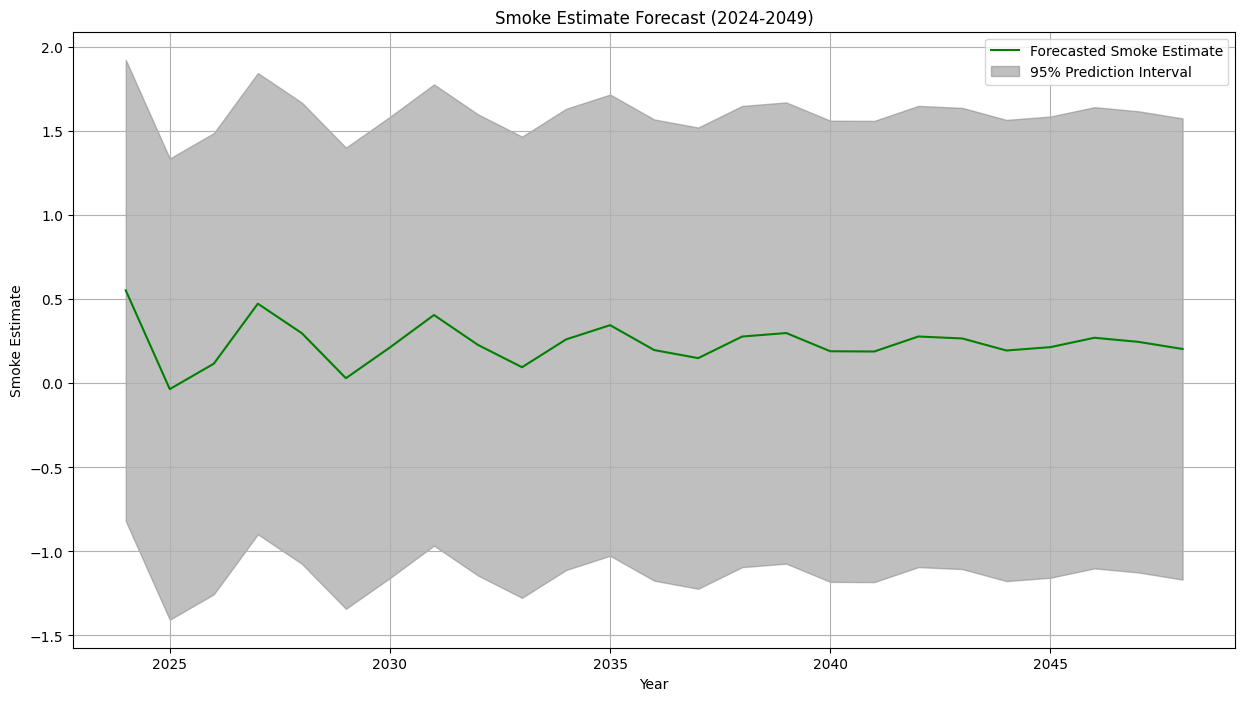

In [94]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define a function to fit ARIMA and forecast
def fit_arima_and_forecast(data, order, forecast_steps):
    try:
        model = ARIMA(data, order=order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=forecast_steps)
        resid = model_fit.resid
        stderr = np.std(resid)
        conf_int = np.column_stack((forecast - stderr * 1.96, forecast + stderr * 1.96))
        return forecast, stderr, conf_int
    except Exception as e:
        print(f"Error fitting ARIMA model with order {order}: {e}")
        raise

# Best ARIMA order based on prior model selection
best_order = (2, 0, 3)
forecast_steps = 25

# Ensure historical data is a Series
historical_data = annual_smoke_estimate['Smoke_estimate']

# Fit ARIMA model and generate forecast
forecast, stderr, conf_int = fit_arima_and_forecast(historical_data, best_order, forecast_steps)

# Create a DataFrame for the forecasted values
years_to_forecast = range(2024, 2049)
forecasted_data = pd.DataFrame({'Year': years_to_forecast, 'Forecasted_Smoke': forecast})

# Add confidence intervals to the DataFrame
forecasted_data['Lower_Bound'] = conf_int[:, 0]
forecasted_data['Upper_Bound'] = conf_int[:, 1]

# Plot the forecast and confidence intervals
plt.figure(figsize=(15, 8))
#plt.plot(annual_smoke_estimate['Year'], annual_smoke_estimate['Smoke_estimate'], label='Historical Smoke Estimate', color='blue')
plt.plot(forecasted_data['Year'], forecasted_data['Forecasted_Smoke'], label='Forecasted Smoke Estimate', color='green')
plt.fill_between(forecasted_data['Year'], forecasted_data['Lower_Bound'], forecasted_data['Upper_Bound'], color='grey', alpha=0.5, label='95% Prediction Interval')
plt.xlabel('Year')
plt.ylabel('Smoke Estimate')
plt.title('Smoke Estimate Forecast (2024-2049)')
plt.legend()
plt.grid()
plt.show()


In [96]:
# Display the forecasted data in the notebook
print(forecasted_data.head())

# Save the forecasted data to a CSV file
#forecasted_data.to_csv("Intermediate output/forecasted_smoke_estimates_2024_2049.csv", index=False)
print("Forecasted data saved to 'forecasted_smoke_estimates_2024_2049.csv'.")


    Year  Forecasted_Smoke  Lower_Bound  Upper_Bound
51  2024          0.553621    -0.818666     1.925908
52  2025         -0.034178    -1.406465     1.338109
53  2026          0.117016    -1.255271     1.489302
54  2027          0.474238    -0.898049     1.846525
55  2028          0.298357    -1.073930     1.670644
Forecasted data saved to 'forecasted_smoke_estimates_2024_2049.csv'.


#### **3. Rationale for Forecasting Methodology**

- **Data Preprocessing**:
  - **Squared Distance in Impact Calculation**: Enhanced the effect of proximity, ensuring closer fires had a proportionally greater contribution to smoke impact. This modification likely reduced the noise in the dataset.

- **Model Selection**:
  - A grid search across \( (p, d, q) \) combinations ensured an objective selection of the best model based on RMSE.
  - The RMSE for the best model (\( 0.6735 \)) is significantly lower than prior runs without squared distance, indicating improved model fit.

- **Model Interpretation**:
  - \( ARIMA(2, 0, 3) \) uses both recent observations (\( p=2 \)) and residual patterns (\( q=3 \)) to make accurate predictions.
  - The stationary nature of the series (\( d=0 \)) simplifies the model while maintaining performance.

- **Prediction Interval**:
  - The wide prediction intervals highlight potential uncertainty in future years, particularly for low-magnitude smoke estimates.

- **Impact of Squared Distance**:
  - Squaring the distance amplified the effect of proximity, effectively reducing noise in the `Smoke_estimate` values and resulting in more stable forecasts.

---

Other attributes that cab potentialy be used to create estimate

Fire Intensity or Tier: If attributes_Fire_Polygon_Tier or attributes_Fire_Attribute_Tiers provides insights into fire intensity or severity, consider incorporating them to weight the impact score further.

# AQI request

In [39]:
import requests
import pandas as pd
from concurrent.futures import ThreadPoolExecutor

api_key = 'baykit84'
email = 'salahmelbakri@gmail.com'
base_url = 'https://aqs.epa.gov/data/api/'

def fetch_aqs_data(year):
    state_code = '53'
    county_code = '033'
    params = {
        'email': email,
        'key': api_key,
        'param': '88101',
        'bdate': f'{year}0501',
        'edate': f'{year}1031',
        'state': state_code,
        'county': county_code
    }
    response = requests.get(f"{base_url}dailyData/byCounty", params=params)
    if response.status_code == 200:
        data = response.json()
        if 'Data' in data and data['Data']:
            return year, pd.DataFrame(data['Data'])
        else:
            print(f"No data available for {year}")
            return year, pd.DataFrame()
    else:
        print(f"Failed to retrieve data for {year}: {response.status_code}")
        return year, pd.DataFrame()

def fetch_aqs_data_for_years_parallel(start_year, end_year):
    aqs_data_by_year = {}
    with ThreadPoolExecutor() as executor:
        results = executor.map(fetch_aqs_data, range(start_year, end_year + 1))
        for year, data in results:
            aqs_data_by_year[year] = data
    return aqs_data_by_year

aqs_data = fetch_aqs_data_for_years_parallel(1999, 2023)


In [ ]:
# This cell is used to confirm the API's response and understand the structure of the data
print(f"Type of aqs_data: {type(aqs_data)}")

# If it's a dictionary, check and print the type of an item (e.g., for the year 2020)
if isinstance(aqs_data, dict):
    print(f"Type of aqs_data for a specific year: {type(aqs_data[2020])}")

    # Print the columns of the DataFrame for the year 2020
    print(f"Columns in aqs_data_2020: {aqs_data[2020].columns}")

    # Print the shape of the DataFrame for the year 2020
    print(f"Shape of aqs_data_2020: {aqs_data[2020].shape}")

    # Print the first few rows of the DataFrame for the year 2020
    print(f"First few rows of aqs_data_2020:\n{aqs_data[2020].head()}")

In [43]:
# Export the AQI data to CSV for integration
all_aqi_data = pd.concat(aqs_data.values(), ignore_index=True)
all_aqi_data.to_csv("aqi_data_renton.csv", index=False)

In [33]:
#all_aqi_data = pd.read_csv('aqi_data_renton.csv')

/var/folders/p8/09r2qr956s5d5st07s90ws340000gn/T/ipykernel_1740/126431064.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  all_aqi_data = pd.read_csv('aqi_data_renton.csv')


In [ ]:
import numpy as np
aqi_means = {year: aqs_data[year]['aqi'].mean() for year in aqs_data.keys() if 'aqi' in aqs_data[year].columns}

# Convert to a DataFrame for consistency with the smoke impact data
df_aqi = pd.DataFrame(list(aqi_means.items()), columns=['Year', 'mean_AQI'])
df_aqi.set_index('Year', inplace=True)


In [ ]:
print(df_aqi.columns)
print(df_aqi.head())


# Visualizations

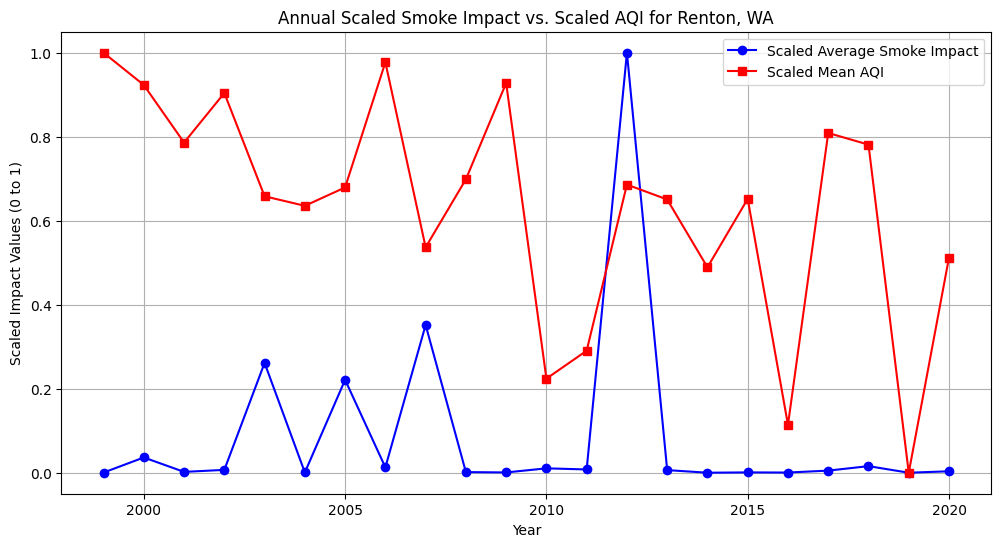

In [102]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Prepare the data for smoke impact
df_smoke = annual_smoke_estimate[['Year', 'Smoke_estimate']].copy()
df_smoke.rename(columns={'Smoke_estimate': 'average_smoke_impact'}, inplace=True)
df_smoke.set_index('Year', inplace=True)

# Ensure df_aqi has the correct Year column and is indexed properly
df_aqi.reset_index(inplace=True)  # Reset index if Year is stored as index
df_aqi.set_index('Year', inplace=True)  # Set Year as index

# Merge the two dataframes to ensure we only have overlapping years
df_combined = df_smoke.join(df_aqi, how='inner')

# Initialize the scaler
scaler = MinMaxScaler()

# Scale both 'average_smoke_impact' and 'mean_AQI' columns to [0, 1]
df_combined[['scaled_smoke_impact', 'scaled_mean_AQI']] = scaler.fit_transform(
    df_combined[['average_smoke_impact', 'mean_AQI']]
)

# Plotting the scaled data
plt.figure(figsize=(12, 6))
plt.plot(df_combined.index, df_combined['scaled_smoke_impact'], label='Scaled Average Smoke Impact', color='blue', marker='o')
plt.plot(df_combined.index, df_combined['scaled_mean_AQI'], label='Scaled Mean AQI', color='red', marker='s')

# Adding titles and labels
plt.title('Annual Scaled Smoke Impact vs. Scaled AQI for Renton, WA')
plt.xlabel('Year')
plt.ylabel('Scaled Impact Values (0 to 1)')
plt.legend()
plt.grid(True)
plt.show()


In [65]:
df_annual_filtered = df_annual[df_annual['shortest_distance_to_renton'] <= 1800]
df_filtered.shape

(39, 36)

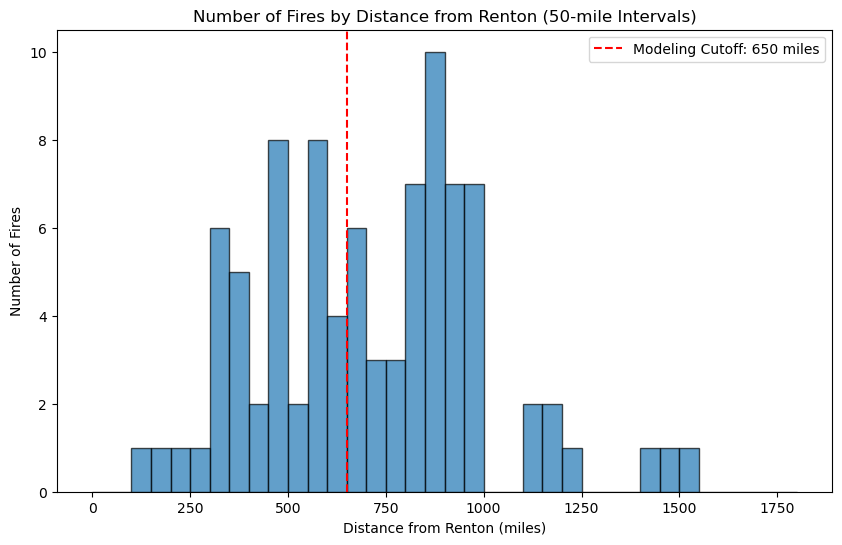

In [206]:
import matplotlib.pyplot as plt


distance_cutoff = 650  


bins = list(range(0, 1801, 50))

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(df_subset['shortest_distance_to_renton'], bins=bins, edgecolor='black', alpha=0.7)
plt.axvline(x=distance_cutoff, color='red', linestyle='--', linewidth=1.5, label=f'Modeling Cutoff: {distance_cutoff} miles')


plt.xlabel('Distance from Renton (miles)')
plt.ylabel('Number of Fires')
plt.title('Number of Fires by Distance from Renton (50-mile Intervals)')
plt.legend()

# Show the plot
plt.show()


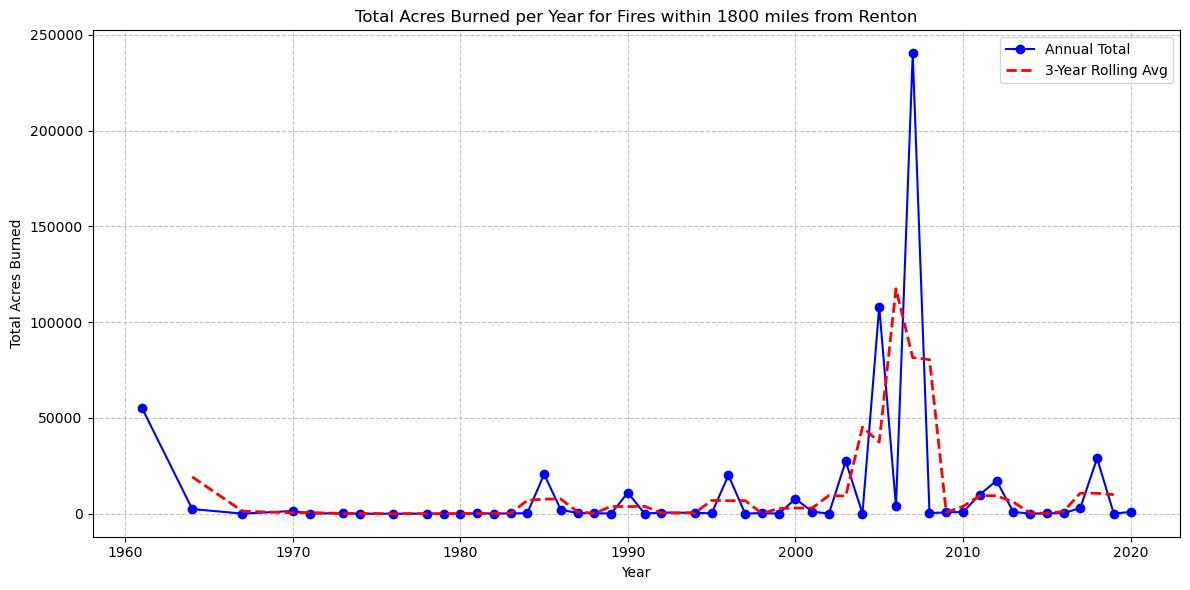

In [207]:

max_distance = 1800
bin_width = 50
bins = range(0, max_distance + bin_width, bin_width)

# Ensure df_subset is within distance range first
df_subset = df_subset[df_subset['shortest_distance_to_renton'] <= max_distance]

acres_burned_per_year = df_subset.groupby('attributes_Fire_Year')['attributes_GIS_Acres'].sum()

acres_burned_per_year_smoothed = acres_burned_per_year.rolling(window=3, center=True).mean()

plt.figure(figsize=(12, 6))
plt.plot(acres_burned_per_year.index, acres_burned_per_year, marker='o', label='Annual Total', color='blue', linewidth=1.5)
plt.plot(acres_burned_per_year.index, acres_burned_per_year_smoothed, linestyle='--', color='red', linewidth=2, label='3-Year Rolling Avg')

# Customize appearance
plt.title('Total Acres Burned per Year for Fires within 1800 miles from Renton')
plt.xlabel('Year')
plt.ylabel('Total Acres Burned')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


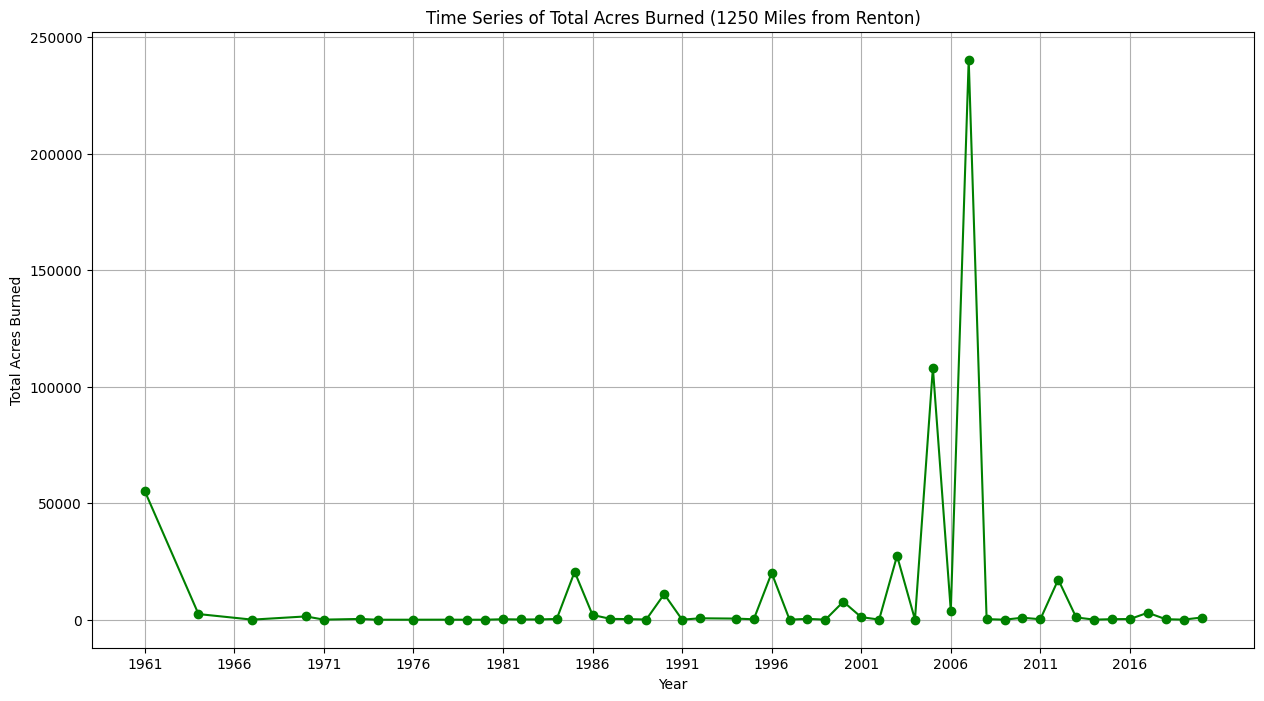

In [104]:
import matplotlib.pyplot as plt

# Define the correct column names based on your DataFrame
year_column = "attributes_Fire_Year"
acres_burned_column = "attributes_GIS_Acres"
distance_column = "shortest_distance_to_renton"

# Define the specified distance (e.g., 1250 miles from your city)
specified_distance = 1250

# Filter the DataFrame to include only fires within the specified distance
filtered_df = df_subset[df_subset[distance_column] <= specified_distance]

# Group the filtered data by year and sum the acres burned in each year
annual_acres_burned = filtered_df.groupby(year_column)[acres_burned_column].sum()

# Create a time series plot
plt.figure(figsize=(15, 8))
plt.plot(annual_acres_burned.index, annual_acres_burned.values, marker='o', linestyle='-', color='green')
plt.xlabel('Year')
plt.ylabel('Total Acres Burned')
plt.title(f'Time Series of Total Acres Burned ({specified_distance} Miles from Renton)')
# Set the x-axis to show years with a 5-year gap
plt.xticks(range(min(annual_acres_burned.index), max(annual_acres_burned.index) + 1, 5))
plt.grid(True)
plt.show()


In [105]:
# Exporting DataFrames to CSV for use for the second part of the analysis

# 1. Export `annual_smoke_estimate`
annual_smoke_estimate.to_csv("annual_smoke_estimate.csv", index=False)

# 2. Export `df_aqi`
df_aqi.reset_index().to_csv("aqi_data.csv", index=False)  # Resetting index to include 'Year' as a column



# 4. Export any other relevant DataFrame
if 'df_subset' in locals():
    df_subset.to_csv("fire_data_filtered.csv", index=False)

print("DataFrames exported as CSV files for use in another notebook.")



DataFrames exported as CSV files for use in another notebook.


# Conclusion

Wildfires have been increasing since the 1980s, with significant smoke impacts near Renton.

Hospital visits correlate strongly with poor air quality during peak wildfire years.